In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
df = pd.read_csv('/content/dataset_komentar_instagram_cyberbullying.csv')
df.tail()

,Id,Sentiment,Instagram Comment Text
395,396,positive,Bangga sama suami yg selalu ingat istri disela...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...
399,400,positive,"<USERNAME> suami saya seumuran sama saya mba,..."


In [3]:
df.Sentiment.value_counts()

negative    200
positive    200
Name: Sentiment, dtype: int64

In [4]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
df = df.drop('Id', axis=1)
df

,Sentiment,Instagram Comment Text
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...
395,1,Bangga sama suami yg selalu ingat istri disela...
396,1,Apaoun pekerjaannya yg penting halal u tuk men...
397,1,Gojek itu mayoritas pegangguran yang lama gak ...
398,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [5]:
df.Sentiment.value_counts()

0    200
1    200
Name: Sentiment, dtype: int64

In [6]:
teks = df['Instagram Comment Text'].values
label = df['Sentiment'].values

In [7]:
teks_latih, teks_test, label_latih, label_test = train_test_split(teks, label, test_size=0.2)

In [8]:
tokenizer = Tokenizer(num_words=250, oov_token='x')
tokenizer.fit_on_texts(teks_latih)
tokenizer.fit_on_texts(teks_test)

sekuens_latih = tokenizer.texts_to_sequences(teks_latih)
sekuens_test = tokenizer.texts_to_sequences(teks_test)

padded_latih = pad_sequences(sekuens_latih, maxlen=20)
padded_test = pad_sequences(sekuens_test, maxlen=20)

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(250, 16, input_length=20),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dropout(0.5), # menambahkan dropout
  tf.keras.layers.Dense(24, activation='relu'), # menambahkan layer Dense
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [10]:
#Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.8 :
      print('\nAkurasi Model Sudah > 90%')
      self.model.stop_training = True

In [11]:
num_epochs = 20
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks = myCallback())

Epoch 1/20
10/10 - 1s - loss: 0.6936 - accuracy: 0.4844 - val_loss: 0.6924 - val_accuracy: 0.5875 - 1s/epoch - 120ms/step
Epoch 2/20
10/10 - 0s - loss: 0.6918 - accuracy: 0.5625 - val_loss: 0.6916 - val_accuracy: 0.5875 - 65ms/epoch - 7ms/step
Epoch 3/20
10/10 - 0s - loss: 0.6900 - accuracy: 0.6062 - val_loss: 0.6897 - val_accuracy: 0.6125 - 53ms/epoch - 5ms/step
Epoch 4/20
10/10 - 0s - loss: 0.6877 - accuracy: 0.6219 - val_loss: 0.6884 - val_accuracy: 0.6125 - 55ms/epoch - 5ms/step
Epoch 5/20
10/10 - 0s - loss: 0.6847 - accuracy: 0.6531 - val_loss: 0.6863 - val_accuracy: 0.6125 - 53ms/epoch - 5ms/step
Epoch 6/20
10/10 - 0s - loss: 0.6828 - accuracy: 0.6313 - val_loss: 0.6841 - val_accuracy: 0.6250 - 67ms/epoch - 7ms/step
Epoch 7/20
10/10 - 0s - loss: 0.6783 - accuracy: 0.6750 - val_loss: 0.6798 - val_accuracy: 0.6250 - 60ms/epoch - 6ms/step
Epoch 8/20
10/10 - 0s - loss: 0.6736 - accuracy: 0.6719 - val_loss: 0.6771 - val_accuracy: 0.6625 - 68ms/epoch - 7ms/step
Epoch 9/20
10/10 - 0s - 

In [12]:
def plot_acc_loss(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[0].plot(history.epoch, history.history['loss'],label = 'Train Loss')
  ax[0].plot(history.epoch, history.history['val_loss'],label = 'Valid Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(history.epoch, history.history['accuracy'],label = 'Train Accuracy')
  ax[1].plot(history.epoch, history.history['val_accuracy'],label = 'Valid Accuracy')
  ax[1].legend()

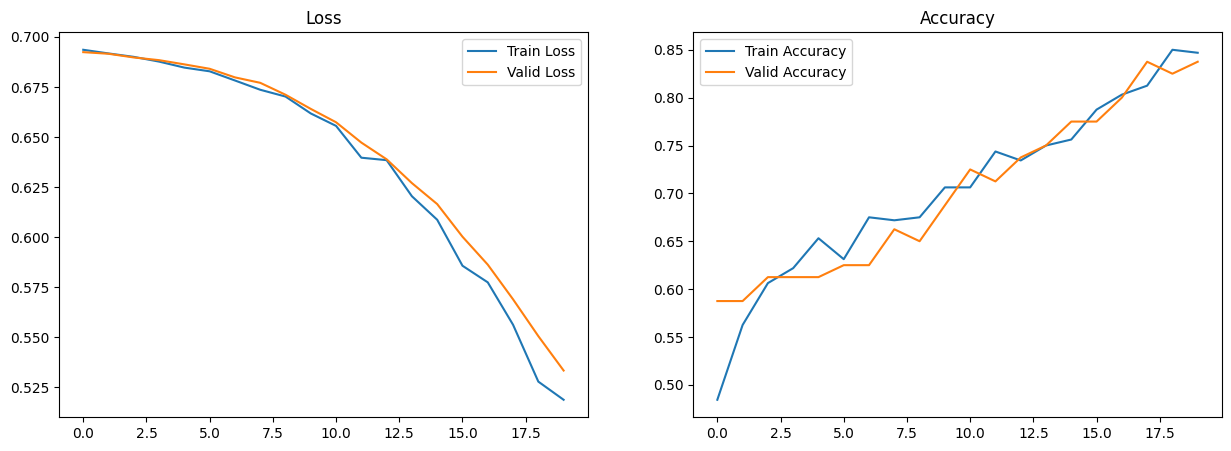

In [13]:
plot_acc_loss(history)

In [14]:
# Save model
model.save('/tmp/saved_model')

In [15]:
load_model = tf.keras.models.load_model('/tmp/saved_model')

In [27]:
new_teks = str(input('Masukkan Teks : '))
max_len = load_model.input_shape[1] # Ambil panjang vektor input yang diharapkan

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([new_teks])
sekuens_teks = tokenizer.texts_to_sequences([new_teks])
padding_teks = pad_sequences(sekuens_teks, maxlen = max_len)

# Melkakukan prediksi
prediction = load_model.predict(padding_teks)

if prediction[0][0] > 0.6704776:
  sentiment = 'Positive'
else :
  sentiment = 'Negative'
persen = round(prediction[0][0] * 100)

print()
print('Teks     :',new_teks)
print('Prediksi :',persen,'%','-',sentiment,'Sentiment')

Masukkan Teks : Bangga banget jadi orang Indonesia
1/1 [==============================] - 0s 21ms/step

Teks     : Bangga banget jadi orang Indonesia
Prediksi : 67 % - Positive Sentiment
